In [8]:
## package imports ##
%load_ext autoreload
%autoreload 2

import sys
import os
import warnings
sys.path.append("../../src")
import utils.preprocessing_utils as process
import utils.query_utils as query
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import synapseclient as sc
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import scipy.stats as stats
from pymatch.Matcher import Matcher
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

warnings.simplefilter("ignore")
sns.set_style("dark")
np.random.seed(100)
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
## helper functions ## 
def annot_phone(params):
    """
    Function to annotate phone types
    returns an annotated dataset with lesser choice of phonetypes
    """
    if ";" in params:
        params = params.split(";")[0]
    if ("iPhone 6+" in params) or ("iPhone 6 Plus" in params):
        return "iPhone 6+"
    if ("iPhone9" in params) or ("Unknown" in params) or ("iPad" in params) or ("iPod" in params):
        return "Other iPhone"
    if ("iPhone 5" in params):
        return "iPhone 5"
    if ("iPhone8" in params):
        return "iPhone 8"
    if ("iPhone X" in params) or ("iPhone10" in params):
        return "iPhone X"
    return params


    

def show_distribution(data, target):
    """
    Function to plot several metadata information accross version 
    """
    data = data[data["version"] != "ems_active"]
    
    dataV1 = data[data["version"] == "mpower_v1"]
    dataV2 = data[data["version"] == "mpower_v2"]

    fig, axes = plt.subplots(nrows = 1, ncols = 3)

    sns.distplot(dataV2["age"].dropna(), label = "V2", ax = axes[0])
    sns.distplot(dataV1["age"].dropna(), label = "V1", ax = axes[0])
    axes[0].legend()
    axes[0].set_title("Age distribution of V1 and V2")
    axes[0].grid()
    axes[0].figure.set_size_inches(15,5)

    sns.countplot(data["PD"], hue = data["version"], ax = axes[1])
    axes[1].legend()
    axes[1].set_title("PD distribution of V1 and V2")
    axes[1].grid()
    axes[1].figure.set_size_inches(15,5)
    
    sns.countplot(data["gender"], hue = data["version"], ax = axes[2])
    axes[2].legend()
    axes[2].set_title("gender distribution of V1 and V2")
    axes[2].grid()
    axes[2].figure.set_size_inches(15,5)
    

     
    
def PCA_plotter(data, feat_cols, 
                metadata_cols, target):
    
    """
    Function to implement PCA with 2 components, 
    then separate them with a target hue variable to see differences

    returns PCA-1 vs PCA-2 plots of metadata and walking features 
    separated by its groups (PD, version)
    """   
    scaler = StandardScaler()
    X_feat = data[feat_cols]
    X_metadata = data[metadata_cols]
    y = data[["version", "healthCode", "PD"]]
    
    lr = LogisticRegression(random_state = 100)
    gb = GradientBoostingClassifier(random_state = 100)
    X_train, X_test, y_train, y_test = train_test_split(X_feat, y[target],
                                                        test_size = 0.2,
                                                        random_state = 100)
    
    gb.fit(X_train, y_train)
    
    print("#################### ASSESSMENT ON %s ################\n" %target)
    print(classification_report(gb.predict(X_test), y_test))
    
    
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))
    
    #Plotting the Cumulative Summation of the Explained Variance
    X_scaled = scaler.fit_transform(X_feat)
    pca = PCA().fit(X_scaled)
    pca = PCA(n_components = 3)
    principal_comp = pca.fit_transform(X_scaled)
    principal_df = pd.DataFrame(data = principal_comp)
    principal_df = pd.concat([principal_df, y], axis = 1)
    
    sns.scatterplot(principal_df[0], principal_df[1], 
                    hue = principal_df[target], ax = axes[0])
    axes[0].set_title("PCA plot on Walking Features")
    axes[0].set_ylabel("PC2")
    axes[0].set_xlabel("PC1")
    axes[0].grid()
    
    
    #Plotting the Cumulative Summation of the Explained Variance
    X_scaled = scaler.fit_transform(X_metadata)
    pca = PCA().fit(X_scaled)
    pca = PCA(n_components = 3)
    principal_comp = pca.fit_transform(X_scaled)
    principal_df = pd.DataFrame(data = principal_comp)
    principal_df = pd.concat([principal_df, y], axis = 1)
    
    sns.scatterplot(principal_df[0], principal_df[1], 
                    hue = principal_df[target], ax = axes[1])
    axes[1].set_title("PCA plot on metadata")
    axes[1].set_ylabel("PC2")
    axes[1].set_xlabel("PC1")
    axes[1].grid()
    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    plt.show()
    

def OHE_data(data):
    """
    Function to one-hot encode the metadata
    it will encode factorial and categorical variables (phonetype, gender and versions)
    returns the encoded dataset, and the result of the encoded columns
    """
    metadata_df = data
    metadata_cols = [feat for feat in metadata_df.columns if ("." not in feat) and ("healthCode" not in feat)]
    # metadata_df = pd.concat([metadata_df, pd.get_dummies(metadata_df["version"])], axis = 1) 
    metadata_df = pd.concat([metadata_df, pd.get_dummies(metadata_df["phone_type"], 
                                                         prefix = "OHE_is")], axis = 1) 
    metadata_df = pd.concat([metadata_df, pd.get_dummies(metadata_df["gender"], 
                                                         drop_first = True, 
                                                         prefix = "OHE_is")], axis = 1)
    metadata_df = pd.concat([metadata_df, pd.get_dummies(metadata_df["version"], 
                                                         drop_first = True, 
                                                         prefix = "OHE_is")], axis = 1)
    OHE_meta_cols = [feat for feat in metadata_df.columns if ("OHE" in feat) or ("age" in feat) or ("PD" in feat)]
    return metadata_df, OHE_meta_cols




def version_balance_hc(data, matching_columns):
    
    """
    Function to create paired healthcodes
    takes in a dataset of PDKIT features

    matching methods:
    Join version 1 and version 2 table by leveraging phone types and gender
    Iterate through each healthcode pairs, and prioritize healthcode pairs that have smaller age differences

    Note: Not joining by PD status due to the non-PD data being discarded significantly

    """
    
    
    ref = pd.pivot_table(data = data, index = "phone_type", columns = "version", values = "PD", aggfunc = "count")
    list_of_spans = ref.loc[(ref["mpower_v1"] > 0) & (ref["mpower_v2"] > 0)].index
    data = data[data["phone_type"].isin(list_of_spans)].reset_index(drop = True)
    
    
    hcx_used = []
    hcy_used = []

    V1 = data[data["version"] == "mpower_v1"][["healthCode", "version", "phone_type", "gender", "PD", "age"]]
    V2 = data[data["version"] == "mpower_v2"][["healthCode", "version", "phone_type", "gender", "PD", "age"]]
    tst_data = pd.merge(V1, V2, on = matching_columns, how = "inner")
    tst_data["age_diff"] = np.abs(tst_data["age_x"] - tst_data["age_y"])
    tst_data = tst_data.sort_values("age_diff").reset_index(drop = True)


    for hc_x, hc_y in zip(tst_data["healthCode_x"], tst_data["healthCode_y"]):

        if (hc_y not in hcy_used) and (hc_x not in hcx_used):
            hcy_used.append(hc_y)
            hcx_used.append(hc_x)

    lst = hcx_used + hcy_used
    return data[data["healthCode"].isin(lst)]



def getKNN_user2user(data, no_neighbors, 
                     distance_metrics, 
                     cols_used):
    
    """
    a function to get K-Nearest Neighbor from user in version 1 to version 2

    ##  pseudocode  ##
    for each healthcode in user 1, find K other pair that is similar in "insert here" similarity metrics
    afterwards, filter the data to only pair the healthcode in version 1 to those in version 2
    then collect all the unique healthcodes that is left after the filter
    """
    data_v1 = data[data["version"] == "mpower_v1"]
    data_v2 = data[data["version"] == "mpower_v2"]
    data = data.set_index("healthCode")
    min_max_scaler = MinMaxScaler()
    walking_features = min_max_scaler.fit_transform(data[cols_used])
    nbrs = NearestNeighbors(n_neighbors = no_neighbors, 
                            algorithm = 'auto', 
                            metric = distance_metrics).fit(walking_features)
    distance, indices = nbrs.kneighbors(walking_features)
    _dict = {}
    _dict["healthCode_ref"] = []
    _dict["healthCode_pair"] = []
    _dict["distance"] = []
    data = data.reset_index()
    for dist, indice in zip(distance, indices):
        for healthcode_idx, _dist in zip(indice[1:], dist[1:]):
            _dict["healthCode_ref"].append(data.ix[indice[0]]["healthCode"])
            _dict["distance"].append(_dist)
            _dict["healthCode_pair"].append(data.ix[healthcode_idx]["healthCode"])
    matches = pd.DataFrame(_dict).sort_values(by = "distance", ascending = False)
    v2_list = data[data["version"] == "mpower_v2"]["healthCode"].unique()
    matches = matches[(~matches["healthCode_ref"].isin(v2_list)) \
        & (matches["healthCode_pair"].isin(v2_list))]
    matched_data = data[(data["healthCode"].isin(matches["healthCode_ref"].unique())) \
                | (data["healthCode"].isin(matches["healthCode_pair"].unique()))].reset_index(drop = True)
    return matched_data


def QaD_correlation(values, classes, isFactor=None):
    """Given a set of values or class assignments determines correlation/enrichment 
    in list of classificiations.
    Uses, correlation or fisher tests
    
    Arguments:
    - `values`:  Vector of values (either numeric or factors)
    - `classes`:  a two dimensional array or pandas DataFrame of (either numeric or factors)
    - `isFactor`: list of same length as classes of T/F indicating weather each 
                  class is a factor or continuous variable (defaults to None) meaning
                  strings are used factors and numbers as continuous
    Returns a list of p-values one for each classification in classes
    """

    isFactor = [None]*len(classes) if isFactor==None else isFactor
    pVals = []
    classes = pd.DataFrame(classes)
    for i, key in enumerate(classes):
        classification = classes[key]
        #If it is a factor perform ANOVA across groups
        if ((classification.dtype in [np.string_,  np.object_, np.bool_, np.unicode_]) or 
            isFactor[i]):
            groupLabels = list(set(classification.dropna()))
            groups = [values[np.where(classification==l)] for l in groupLabels]
            f_val, p_val = stats.f_oneway(*groups) 
            #if np.isnan(p_val):
            #    print groupLabels
            pVals.append(p_val)
            #print list(set(classification)), p_val
        #If it is not a factor perform correlation analysis
        else:
            m, b, r_val, p_val, slope_std_error = stats.linregress(values, classification)
            pVals.append(p_val)
    pVals = np.asarray(pVals)
    pVals[np.isnan(pVals)] = np.inf
    series = pd.Series(data = pVals, index = classes.columns)
    return series

# Introduction:

This notebook will explore preliminary techniques to reduce confounding effects of the metadata.
To compare metadata, some additional approaches will be taken, such as:

1. One hot encoding of the phone types, version and gender 
2. Age distribution of the version 2 and passive data will be set to have same the lowest values as the lowest values from version 1, for sustaining the same distribution

Afterwards, several matching of cases (by combination of metadata matchings) will be analyzed to see whether the confounding effects can be curated
1. phone type matching to subject in version 1 and those in version 2
2. phone type and gender matching 
3. phone type and PD matching
4. phone type, PD and gender matching
5. by feature similarity

Visualized PCA of PC1 vs PC2 of walking features and metadata will be assessed to see if there is still any separations between two versions. A simple baseline classifier (gradient boosting) will be implemented to see whether the model can actually predict the versions of the mobile app, which is a good benchmark towards knowing whether there are still confounding effects sourced from the metadata.

In [98]:
syn = sc.login()
data = query.get_file_entity(syn, "syn21281633")

Welcome, aryton tediarjo!



In [99]:
## concatenate dataset and annotate iphone type ## 
dataV1 = data[data["version"] == "mpower_v1"]
dataV2 = data[data["version"] == "mpower_v2"]
data = pd.concat([dataV1, dataV2]).reset_index(drop = True)
data = process.addFeatures().transform(data)
data = process.collapseFeatures(aggregation_type = "max").transform(data)
data["phone_type"] = data["phoneInfo"].apply(annot_phone)
data = data[[feat for feat in data.columns if "0" not in feat]]

### Type of phones that span accross versions 

In [100]:
pd.pivot_table(data = data, index = "phone_type", columns = "version", values = "PD", aggfunc = "count")

version,mpower_v1,mpower_v2
phone_type,,
Other iPhone,90.0,29.0
iPhone 4S,17.0,NaN
iPhone 5,1139.0,8.0
iPhone 6,2016.0,36.0
iPhone 6+,1256.0,12.0
iPhone 6S,NaN,31.0
iPhone 6S+,NaN,12.0
iPhone 7,NaN,39.0
iPhone 7+,NaN,25.0


### Type of phones and PD subject that span accross versions 

In [101]:
pd.pivot_table(data    = data, 
               index   = "phone_type", 
               columns = ["version", "PD"], 
               values  = "healthCode", 
               aggfunc = "count")

version      mpower_v1        mpower_v2      
PD                 0.0    1.0       0.0   1.0
phone_type                                   
Other iPhone      20.0   70.0       8.0  21.0
iPhone 4S          3.0   14.0       NaN   NaN
iPhone 5         749.0  390.0       NaN   8.0
iPhone 6        1566.0  450.0       5.0  31.0
iPhone 6+        999.0  257.0       NaN  12.0
iPhone 6S          NaN    NaN       6.0  25.0
iPhone 6S+         NaN    NaN       NaN  12.0
iPhone 7           NaN    NaN       7.0  32.0
iPhone 7+          NaN    NaN       3.0  22.0
iPhone 8          85.0  165.0       6.0  32.0
iPhone 8+          NaN    NaN       3.0  14.0
iPhone SE          NaN    NaN       1.0  15.0
iPhone X           8.0   29.0       9.0  24.0

From the tabular dataframe above, we can see that there are only several phones that spans accross the two versions. Especially when broken down further to matching by their PDs status, there will be an issue where we will not get enough controls as most of the controls are not recruited to the version two studies (yet)

# Visualization & Intepretation

### 1.) Pre-matching Dataset (default)

In [102]:
## get encoded data
encoded_data = OHE_data(data)[0]

## column feature lists
walking_feat_cols = [feat for feat in data.columns if "." in feat]
metadata_feat_cols = [feat for feat in data.columns if ("." not in feat) and ("healthCode" not in feat)]
OHE_feat_cols = OHE_data(data)[1]

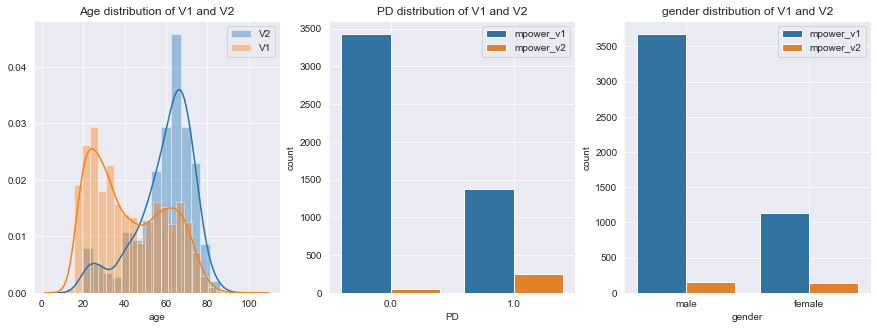

In [103]:
show_distribution(encoded_data[metadata_feat_cols], "version")

#################### ASSESSMENT ON version ################

              precision    recall  f1-score   support

   mpower_v1       0.98      0.97      0.97       969
   mpower_v2       0.50      0.63      0.56        52

    accuracy                           0.95      1021
   macro avg       0.74      0.80      0.77      1021
weighted avg       0.96      0.95      0.95      1021



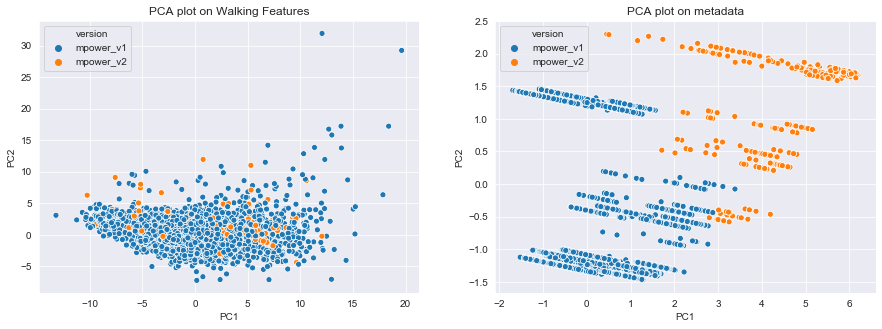

#################### ASSESSMENT ON PD ################

              precision    recall  f1-score   support

         0.0       0.94      0.82      0.88       804
         1.0       0.55      0.80      0.65       217

    accuracy                           0.82      1021
   macro avg       0.74      0.81      0.76      1021
weighted avg       0.85      0.82      0.83      1021



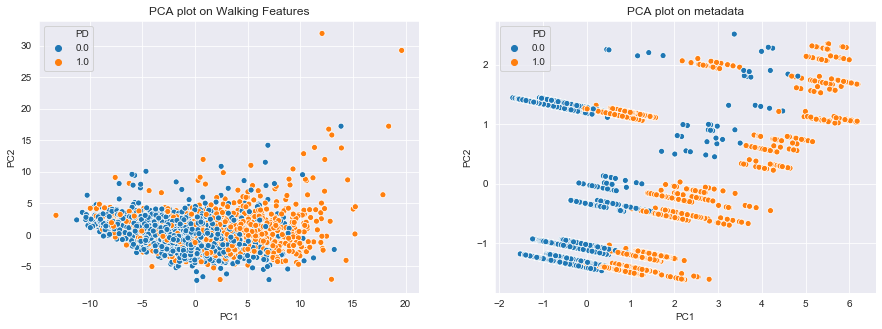

In [104]:
PCA_plotter(encoded_data, walking_feat_cols, OHE_feat_cols, "version")
PCA_plotter(encoded_data, walking_feat_cols, OHE_feat_cols, "PD")

The prematching plot shows that there are a very large separation accross the versions, which means that there might be some signals on the metadata. As seen from how a simple GradientBoosting can classify the versions, it is imperative to subsample our dataset so that our metadata will confound the predictive capability of the walking features that will be implemented.

### 2.) Matched Dataset by Phone Types

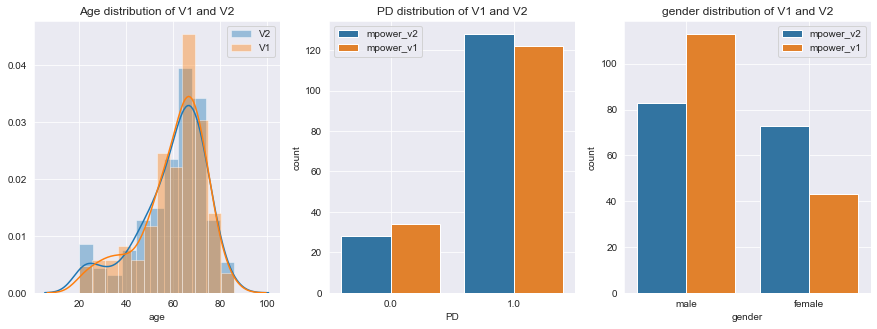

In [24]:
balance_hc_data = version_balance_hc(encoded_data, ["phone_type"]).reset_index(drop = True)
show_distribution(balance_hc_data[metadata_feat_cols], "version")

#################### ASSESSMENT ON version ################

              precision    recall  f1-score   support

   mpower_v1       0.72      0.66      0.69        35
   mpower_v2       0.61      0.68      0.64        28

    accuracy                           0.67        63
   macro avg       0.67      0.67      0.67        63
weighted avg       0.67      0.67      0.67        63



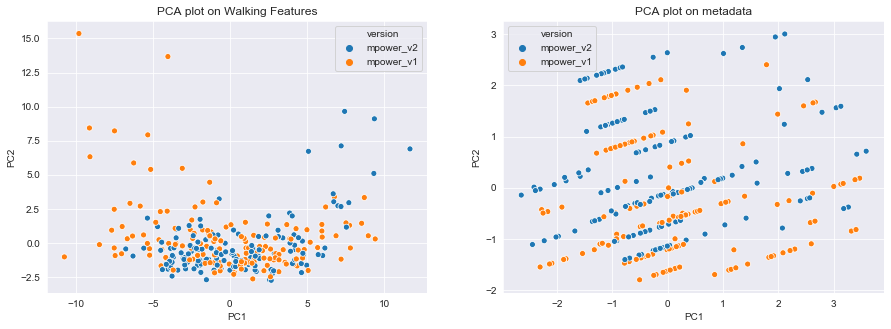

#################### ASSESSMENT ON PD ################

              precision    recall  f1-score   support

         0.0       0.29      0.50      0.37        10
         1.0       0.89      0.77      0.83        53

    accuracy                           0.73        63
   macro avg       0.59      0.64      0.60        63
weighted avg       0.80      0.73      0.76        63



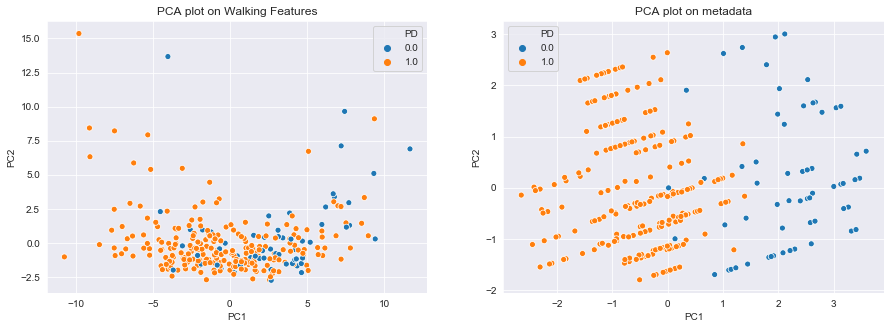

In [25]:
PCA_plotter(balance_hc_data, walking_feat_cols, OHE_feat_cols, "version")
PCA_plotter(balance_hc_data, walking_feat_cols, OHE_feat_cols, "PD")

By matching using spanning phone types, gender, and closest age differences, we can see that PCs are more evenly spread accross version 1 and version 2, however still slightly separable as most of the version 1 is on the upper area of the plot. In terms of its walking features, it is apparent that version 1 and version 2 is still linearly separable from each other. 

The reason why most of the V1s are lying on top is due to the uneven distribution of non-PD in our data collections, especially as most of the V1 has far more Non-PD data.

## 3a.) Matched Dataset by Phone Types, Gender, and PD

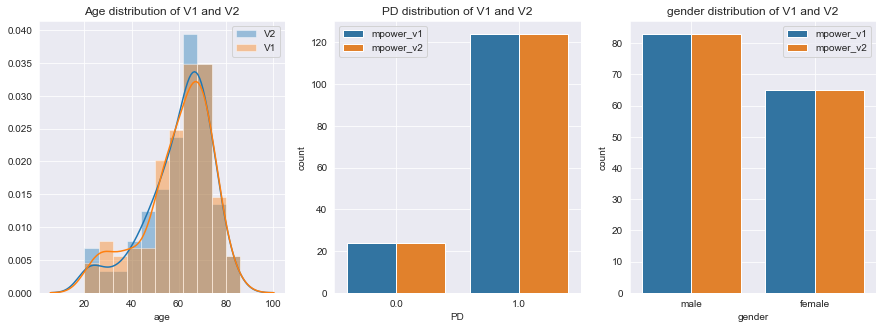

In [26]:
balance_hc_data = version_balance_hc(encoded_data, ["phone_type", "PD", "gender"]).reset_index(drop = True)
show_distribution(balance_hc_data[metadata_feat_cols], "version")

#################### ASSESSMENT ON version ################

              precision    recall  f1-score   support

   mpower_v1       0.90      0.51      0.66        37
   mpower_v2       0.54      0.91      0.68        23

    accuracy                           0.67        60
   macro avg       0.72      0.71      0.67        60
weighted avg       0.76      0.67      0.66        60



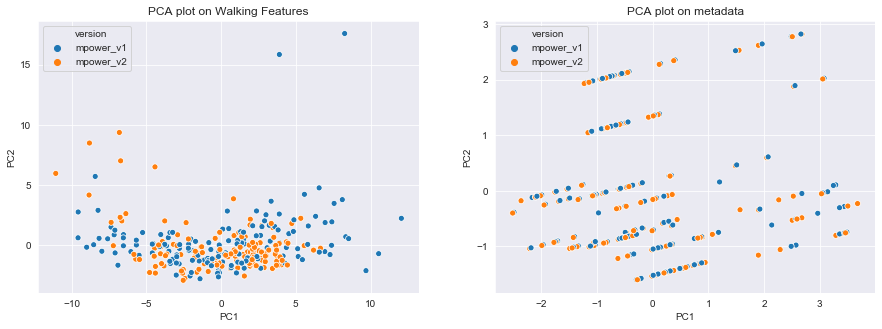

#################### ASSESSMENT ON PD ################

              precision    recall  f1-score   support

         0.0       0.14      0.20      0.17         5
         1.0       0.92      0.89      0.91        55

    accuracy                           0.83        60
   macro avg       0.53      0.55      0.54        60
weighted avg       0.86      0.83      0.85        60



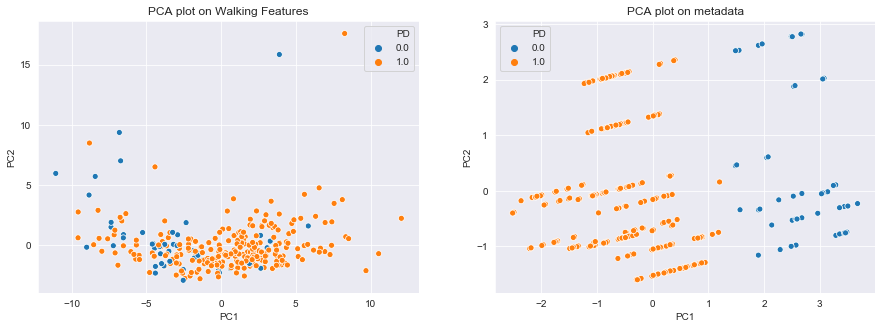

In [27]:
PCA_plotter(balance_hc_data, walking_feat_cols, OHE_feat_cols, "version")
PCA_plotter(balance_hc_data, walking_feat_cols, OHE_feat_cols, "PD")

### 4.) Use Similarity Metrics on Features

In [138]:
matched_data = getKNN_user2user(data, 10, "euclidean", walking_feat_cols)
matched_data_encoded = OHE_data(matched_data)[0]
OHE_feat_cols = OHE_data(matched_data)[1]

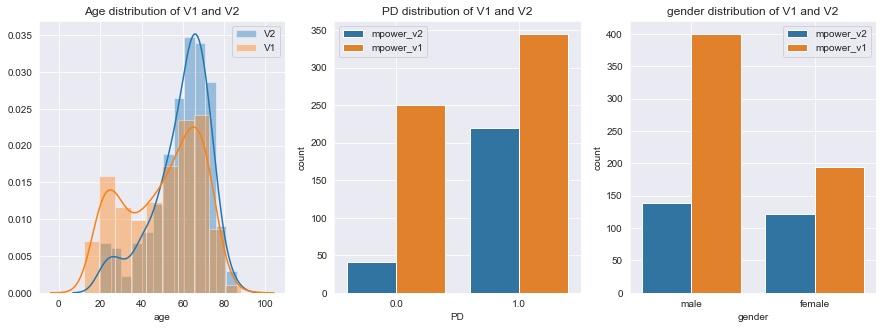

In [66]:
show_distribution(matched_data_encoded, "version")

#################### ASSESSMENT ON version ################

              precision    recall  f1-score   support

   mpower_v1       0.92      0.77      0.84       137
   mpower_v2       0.46      0.74      0.57        35

    accuracy                           0.77       172
   macro avg       0.69      0.76      0.70       172
weighted avg       0.83      0.77      0.79       172



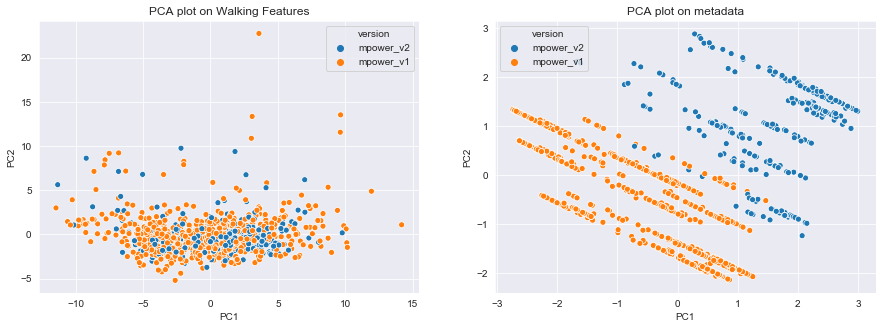

#################### ASSESSMENT ON PD ################

              precision    recall  f1-score   support

         0.0       0.63      0.68      0.65        53
         1.0       0.85      0.82      0.84       119

    accuracy                           0.78       172
   macro avg       0.74      0.75      0.75       172
weighted avg       0.78      0.78      0.78       172



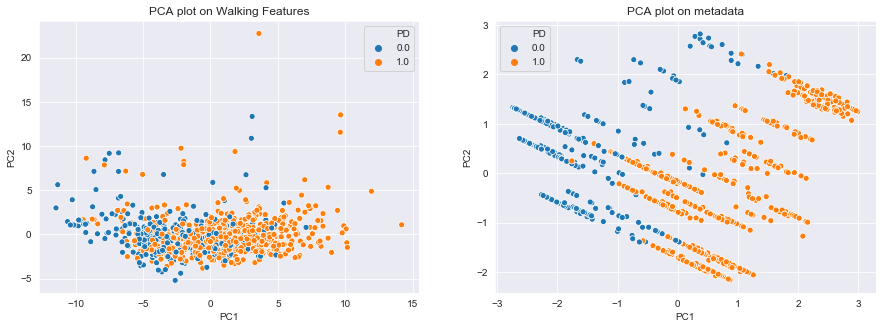

In [67]:
PCA_plotter(matched_data_encoded, walking_feat_cols, OHE_feat_cols, "version")
PCA_plotter(matched_data_encoded, walking_feat_cols, OHE_feat_cols, "PD")

# Metadata Associations

This section will see whether each metadata still has association towards other metadatas, we will test the subgroups of whether the subject is_male, is_v2, is_PD 
against each of the metadata. The ideal case is to have large p-value (>0.05), meaning that the metadata association is almost nonexistent to all the other metadata. However if p-value is extremely low we will assume that there are some associations on the metadata to other metadata, which is something that we would like to avoid.

## One-Way Anova Association on Metadata

In [18]:
def print_pvals_ftest(data, group):
    metadata_df = OHE_data(data)[0]
    OHE_cols = OHE_data(data)[1]
    return QaD_correlation(metadata_df[group], metadata_df[OHE_cols])

## 1.) Before Matching

In [19]:
print("### Gender ####")
print_pvals_ftest(data, "OHE_is_male")

### Gender ####


PD                     3.888508e-43
age                    5.014677e-29
OHE_is_Other iPhone    4.380598e-02
OHE_is_iPhone 4S       3.197581e-01
OHE_is_iPhone 5        5.293040e-04
OHE_is_iPhone 6        2.460403e-04
OHE_is_iPhone 6+       1.864655e-11
OHE_is_iPhone 6S       2.501607e-06
OHE_is_iPhone 6S+      1.780720e-01
OHE_is_iPhone 7        5.434177e-04
OHE_is_iPhone 7+       2.661389e-02
OHE_is_iPhone 8        1.054662e-11
OHE_is_iPhone 8+       1.179034e-03
OHE_is_iPhone SE       5.549042e-01
OHE_is_iPhone X        6.675720e-02
OHE_is_male            0.000000e+00
OHE_is_mpower_v2       1.905786e-21
dtype: float64

In [20]:
print("### age ###")
print_pvals_ftest(data, "age")

### age ###


PD                     0.000000e+00
age                    0.000000e+00
OHE_is_Other iPhone    2.584670e-12
OHE_is_iPhone 4S       7.262453e-07
OHE_is_iPhone 5        2.503898e-01
OHE_is_iPhone 6        1.230133e-19
OHE_is_iPhone 6+       4.562079e-06
OHE_is_iPhone 6S       3.893363e-06
OHE_is_iPhone 6S+      3.507121e-04
OHE_is_iPhone 7        8.440496e-10
OHE_is_iPhone 7+       5.353025e-06
OHE_is_iPhone 8        4.263313e-21
OHE_is_iPhone 8+       2.852452e-02
OHE_is_iPhone SE       7.511303e-05
OHE_is_iPhone X        2.535039e-09
OHE_is_male            5.014677e-29
OHE_is_mpower_v2       1.356113e-57
dtype: float64

In [22]:
## association in version groupings
print("### version ###")
print_pvals_ftest(data, "OHE_is_mpower_v2")

### version ###


PD                      1.840473e-90
age                     1.356113e-57
OHE_is_Other iPhone     1.403224e-18
OHE_is_iPhone 4S        3.054294e-01
OHE_is_iPhone 5         3.542140e-17
OHE_is_iPhone 6         2.087670e-24
OHE_is_iPhone 6+        1.114295e-17
OHE_is_iPhone 6S       6.391792e-118
OHE_is_iPhone 6S+       3.461721e-45
OHE_is_iPhone 7        3.657973e-150
OHE_is_iPhone 7+        2.151174e-94
OHE_is_iPhone 8         3.192972e-08
OHE_is_iPhone 8+        7.678918e-64
OHE_is_iPhone SE        4.386607e-60
OHE_is_iPhone X         3.025533e-51
OHE_is_male             1.905786e-21
OHE_is_mpower_v2        0.000000e+00
dtype: float64

In [23]:
## association in duration groupings
print("### PD ###")
print_pvals_ftest(data, "PD")

### PD ###


PD                     0.000000e+00
age                    0.000000e+00
OHE_is_Other iPhone    1.971241e-26
OHE_is_iPhone 4S       7.313428e-06
OHE_is_iPhone 5        1.730178e-02
OHE_is_iPhone 6        3.207937e-26
OHE_is_iPhone 6+       6.035139e-21
OHE_is_iPhone 6S       4.542495e-09
OHE_is_iPhone 6S+      3.731069e-07
OHE_is_iPhone 7        1.245567e-11
OHE_is_iPhone 7+       1.400458e-09
OHE_is_iPhone 8        1.288322e-43
OHE_is_iPhone 8+       7.313428e-06
OHE_is_iPhone SE       9.646657e-08
OHE_is_iPhone X        1.683849e-15
OHE_is_male            3.888508e-43
OHE_is_mpower_v2       1.840473e-90
dtype: float64

## 2.) After Phone Type, Gender Based (Treatment: Version)

In [139]:
balance_hc_data = version_balance_hc(data, ["phone_type", "gender"]).reset_index(drop = True)

In [140]:
print("### gender ###")
print_pvals_ftest(balance_hc_data, "OHE_is_male")

### gender ###


PD                     0.147146
age                    0.538146
OHE_is_Other iPhone    0.005080
OHE_is_iPhone 5        0.615731
OHE_is_iPhone 6        0.517814
OHE_is_iPhone 6+       0.138657
OHE_is_iPhone 8        0.020769
OHE_is_iPhone X        0.062830
OHE_is_male            0.000000
OHE_is_mpower_v2       1.000000
dtype: float64

In [141]:
print("### age ###")
print_pvals_ftest(balance_hc_data, "age")

### age ###


PD                     1.777214e-29
age                    0.000000e+00
OHE_is_Other iPhone    5.076782e-01
OHE_is_iPhone 5        6.356844e-03
OHE_is_iPhone 6        7.362858e-01
OHE_is_iPhone 6+       1.438036e-04
OHE_is_iPhone 8        6.675499e-01
OHE_is_iPhone X        5.062780e-03
OHE_is_male            5.381460e-01
OHE_is_mpower_v2       9.547871e-01
dtype: float64

In [142]:
print("### version ###")
print_pvals_ftest(balance_hc_data, "OHE_is_mpower_v2")

### version ###


PD                     0.048282
age                    0.954787
OHE_is_Other iPhone    1.000000
OHE_is_iPhone 5        1.000000
OHE_is_iPhone 6        1.000000
OHE_is_iPhone 6+       1.000000
OHE_is_iPhone 8        1.000000
OHE_is_iPhone X        1.000000
OHE_is_male            1.000000
OHE_is_mpower_v2       0.000000
dtype: float64

In [143]:
print("### PD ###")
print_pvals_ftest(balance_hc_data, "PD")

### PD ###


PD                     0.000000e+00
age                    1.777214e-29
OHE_is_Other iPhone    8.481571e-01
OHE_is_iPhone 5        3.638403e-01
OHE_is_iPhone 6        1.456377e-01
OHE_is_iPhone 6+       2.589716e-01
OHE_is_iPhone 8        6.447256e-01
OHE_is_iPhone X        6.553751e-01
OHE_is_male            1.471464e-01
OHE_is_mpower_v2       4.828214e-02
dtype: float64

## 3.) By Phone Type, Gender, PD Matching

In [144]:
balance_hc_data = version_balance_hc(data, ["phone_type", "gender", "PD"]).reset_index(drop = True)

In [145]:
print("### gender ###")
print_pvals_ftest(balance_hc_data, "OHE_is_male")

### gender ###


PD                     0.329255
age                    0.633838
OHE_is_Other iPhone    0.005080
OHE_is_iPhone 5        0.615731
OHE_is_iPhone 6        0.517814
OHE_is_iPhone 6+       0.138657
OHE_is_iPhone 8        0.020769
OHE_is_iPhone X        0.062830
OHE_is_male            0.000000
OHE_is_mpower_v2       1.000000
dtype: float64

In [146]:
print("### age ###")
print_pvals_ftest(balance_hc_data, "age")

### age ###


PD                     1.124701e-44
age                    0.000000e+00
OHE_is_Other iPhone    1.510949e-01
OHE_is_iPhone 5        6.008355e-03
OHE_is_iPhone 6        8.187080e-01
OHE_is_iPhone 6+       1.584712e-04
OHE_is_iPhone 8        7.213470e-01
OHE_is_iPhone X        2.936882e-02
OHE_is_male            6.338379e-01
OHE_is_mpower_v2       7.653097e-01
dtype: float64

In [147]:
print("### version ###")
print_pvals_ftest(balance_hc_data, "OHE_is_mpower_v2")

### version ###


PD                     1.00000
age                    0.76531
OHE_is_Other iPhone    1.00000
OHE_is_iPhone 5        1.00000
OHE_is_iPhone 6        1.00000
OHE_is_iPhone 6+       1.00000
OHE_is_iPhone 8        1.00000
OHE_is_iPhone X        1.00000
OHE_is_male            1.00000
OHE_is_mpower_v2       0.00000
dtype: float64

In [148]:
print("### PD ###")
print_pvals_ftest(balance_hc_data, "PD")

### PD ###


PD                     0.000000e+00
age                    1.124701e-44
OHE_is_Other iPhone    8.688158e-03
OHE_is_iPhone 5        7.080855e-02
OHE_is_iPhone 6        5.395701e-01
OHE_is_iPhone 6+       2.454581e-02
OHE_is_iPhone 8        9.071946e-01
OHE_is_iPhone X        4.276150e-01
OHE_is_male            3.292545e-01
OHE_is_mpower_v2       1.000000e+00
dtype: float64

## 4.) By Feature Similarity Distance Metrics

In [92]:
similarity_matched_data = matched_data

In [93]:
print("### gender ###")
print_pvals_ftest(similarity_matched_data, "OHE_is_male")

### gender ###


PD                     0.027372
age                    0.001422
OHE_is_Other iPhone    0.090561
OHE_is_iPhone 4S       0.894407
OHE_is_iPhone 5        0.088099
OHE_is_iPhone 6        0.017330
OHE_is_iPhone 6+       0.002515
OHE_is_iPhone 6S       0.004510
OHE_is_iPhone 6S+      0.560976
OHE_is_iPhone 7        0.149236
OHE_is_iPhone 7+       0.365725
OHE_is_iPhone 8        0.003697
OHE_is_iPhone 8+       0.116425
OHE_is_iPhone SE       0.765009
OHE_is_iPhone X        0.331520
OHE_is_male            0.000000
OHE_is_mpower_v2       0.000093
dtype: float64

In [94]:
print("### age ###")
print_pvals_ftest(similarity_matched_data, "age")

### age ###


PD                     2.456460e-138
age                     0.000000e+00
OHE_is_Other iPhone     1.365458e-01
OHE_is_iPhone 4S        4.435800e-01
OHE_is_iPhone 5         5.727763e-01
OHE_is_iPhone 6         1.336492e-07
OHE_is_iPhone 6+        8.539735e-04
OHE_is_iPhone 6S        2.436410e-01
OHE_is_iPhone 6S+       1.418545e-01
OHE_is_iPhone 7         5.633367e-03
OHE_is_iPhone 7+        5.002239e-02
OHE_is_iPhone 8         4.933717e-03
OHE_is_iPhone 8+        9.143214e-01
OHE_is_iPhone SE        6.070627e-02
OHE_is_iPhone X         3.950345e-01
OHE_is_male             1.422224e-03
OHE_is_mpower_v2        1.563410e-12
dtype: float64

In [95]:
print("### version ###")
print_pvals_ftest(similarity_matched_data, "OHE_is_mpower_v2")

### version ###


PD                     3.049188e-14
age                    1.563410e-12
OHE_is_Other iPhone    5.678324e-01
OHE_is_iPhone 4S       2.509954e-01
OHE_is_iPhone 5        1.507437e-11
OHE_is_iPhone 6        1.121940e-07
OHE_is_iPhone 6+       6.032475e-08
OHE_is_iPhone 6S       9.399394e-14
OHE_is_iPhone 6S+      3.962805e-07
OHE_is_iPhone 7        9.511910e-21
OHE_is_iPhone 7+       2.545978e-14
OHE_is_iPhone 8        1.896286e-02
OHE_is_iPhone 8+       9.307511e-09
OHE_is_iPhone SE       2.645196e-09
OHE_is_iPhone X        5.845178e-05
OHE_is_male            9.290871e-05
OHE_is_mpower_v2       0.000000e+00
dtype: float64

In [96]:
print("### PD ###")
print_pvals_ftest(similarity_matched_data, "PD")

### PD ###


PD                      0.000000e+00
age                    2.456460e-138
OHE_is_Other iPhone     3.275969e-02
OHE_is_iPhone 4S        9.806829e-01
OHE_is_iPhone 5         9.217836e-01
OHE_is_iPhone 6         2.921490e-08
OHE_is_iPhone 6+        4.177080e-06
OHE_is_iPhone 6S        2.088924e-01
OHE_is_iPhone 6S+       1.656628e-02
OHE_is_iPhone 7         3.164159e-02
OHE_is_iPhone 7+        7.064730e-03
OHE_is_iPhone 8         2.769009e-04
OHE_is_iPhone 8+        1.167482e-01
OHE_is_iPhone SE        2.417556e-02
OHE_is_iPhone X         4.279223e-01
OHE_is_male             2.737220e-02
OHE_is_mpower_v2        3.049188e-14
dtype: float64

## Notes

The graph above shows that matching by all PDs, Gender and Phone types is the best way to remove the associations of the metadata to the versions. However, it comes at a cost of removing all the version 2 users. However, this might be the best subsample moving forward as we will be collecting more mPower2 data

# Separation in PCA?

In [59]:
data = query.get_file_entity(syn, "syn21281633")
healthcode_list_v1 = query.get_file_entity(syn, "syn8381056").index
data = data[[feat for feat in data.columns if "0" not in feat]]
dataV1 = data[data["healthCode"].isin(healthcode_list_v1)]
dataV2 = data[data["version"] == "mpower_v2"]
data = pd.concat([dataV1, dataV2]).reset_index(drop = True)
data = process.addFeatures().transform(data)
data = process.collapseFeatures(aggregation_type = "max").transform(data)
data["phone_type"] = data["phoneInfo"].apply(annot_phone)
# data = data[data["nrecords"] >= 3].reset_index(drop = True)

In [60]:
## get encoded data
encoded_data = OHE_data(data)[0]

## column feature lists
walking_feat_cols = [feat for feat in data.columns if "." in feat]
metadata_feat_cols = [feat for feat in data.columns if ("." not in feat) and ("healthCode" not in feat)]
OHE_feat_cols = OHE_data(data)[1]

#################### ASSESSMENT ON version ################

              precision    recall  f1-score   support

   mpower_v1       1.00      1.00      1.00        41
   mpower_v2       1.00      1.00      1.00        57

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98



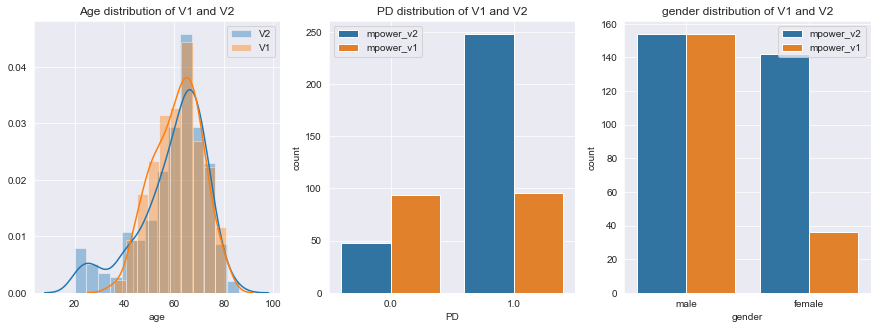

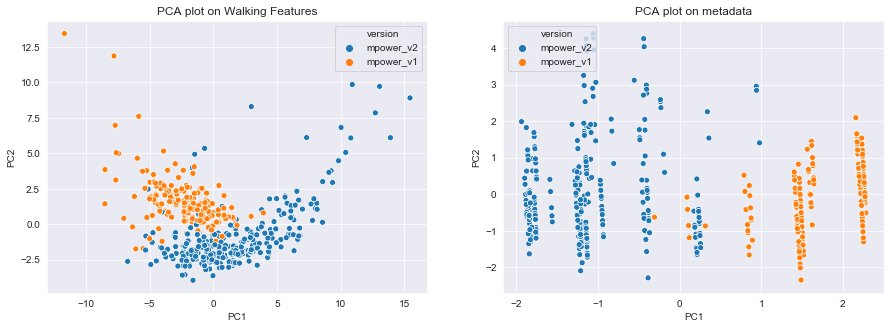

#################### ASSESSMENT ON PD ################

              precision    recall  f1-score   support

         0.0       0.42      0.58      0.49        19
         1.0       0.89      0.81      0.85        79

    accuracy                           0.77        98
   macro avg       0.66      0.69      0.67        98
weighted avg       0.80      0.77      0.78        98



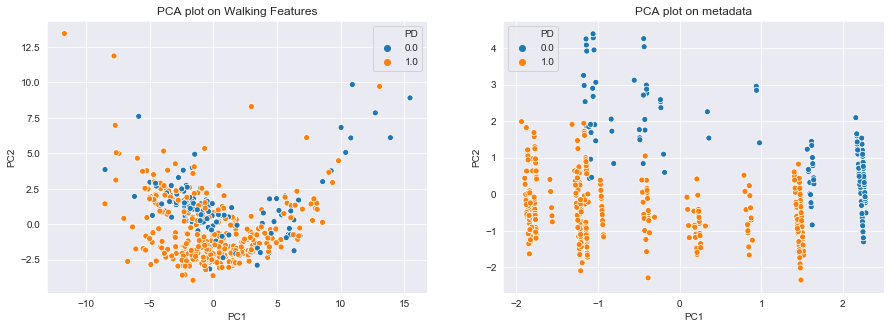

In [63]:
show_distribution(encoded_data[metadata_feat_cols], "version")
PCA_plotter(encoded_data, walking_feat_cols, OHE_feat_cols, "version")
PCA_plotter(encoded_data, walking_feat_cols, OHE_feat_cols, "PD")